# 로지스틱 회귀
* 로지스틱 회귀는 선형 회귀방식을 분류에 적용한 알고리즘. 
* 로지스틱 회귀가 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아닌 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것.
* 시그모이드 함수의 정의 : $y = {1 \over 1 + e^-x}$

## 위스콘신 유방암 세트를 이용해 암 예측
* 로지스틱 회귀 방법 적용

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

### 학습세트와 테스트세트 분리
* 선형회귀 계열의 로지스틱 회귀는 데이터의 정규분포에 따라 예측성능이 달라질수있으므로 먼저 정규분포 형태의 표준스케일링이 필요(학습/테스트 세트 분리전 수행하는것이 바람직)

#### StandardScaler적용

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0이고 분산 1로 데이터 분포도 전환
scaler = StandardScaler()

data_scaled = scaler.fit_transform(cancer.data)

display(data_scaled.shape)
seed = 156
np.random.seed(seed)

(569, 30)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = seed)

### **로지스틱회귀를 이용해 학습 / 예측 수행**
* 정확도와 ROC AUC값 
* 주요 하이퍼 파라미터
  - `penalty` - l1, l2가 있으면 기본값은 l2, `C` - 이 값이 작을 수록 규제강도가 크다.

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, Y_train)

# 예측
lr_preds = lr_clf.predict(X_test)

# 정확도와 ROC AUC Score
print('accuracy : {0:.3f}'.format(accuracy_score(Y_test, lr_preds)))
print("ROC AUC Score : {0:.3f}".format(roc_auc_score(Y_test, lr_preds)))

accuracy : 0.965
ROC AUC Score : 0.956


**GridSearchCV를 이용해 하이퍼 파라미터 최적화**

In [24]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1', 'l2'],
           'C': [0.01, 0.1, 1, 1, 5, 10]}
grid_clf = GridSearchCV(estimator = lr_clf, param_grid = params , scoring ='accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)

print("최적 하이퍼 파라미터 : {0}, 최적 평균 정확도 : {1:.3f}".format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도 : 0.975


### **실데이터를 통한 예측정확도 비교**

In [42]:
Y_prediction = lr_clf.predict(X_test).flatten()

In [46]:
for i in range(10):
    label = Y_test[i]
    prediction  = Y_prediction[i]
    print("실제 판정 :{0}, 예측판정 : {1}".format(label, prediction))

실제 판정 :1, 예측판정 : 1
실제 판정 :0, 예측판정 : 0
실제 판정 :1, 예측판정 : 1
실제 판정 :0, 예측판정 : 0
실제 판정 :1, 예측판정 : 1
실제 판정 :1, 예측판정 : 1
실제 판정 :1, 예측판정 : 1
실제 판정 :1, 예측판정 : 1
실제 판정 :1, 예측판정 : 1
실제 판정 :0, 예측판정 : 0


* 로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어납니다. 이 때문에 로지스틱 회귀를 이진 분류의 기본 모델로 사용하는 경우가 많습니다. 또한 로지스틱 회귀는 희소한 데이터세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에서 자주 사용됨.

# 회귀트리

## RandomForestRegressor를 이용한 보스턴 주택 가격 예측

In [78]:
# 라이브러리 로드 
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

### 보스턴 데이터셋 로드

In [125]:
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

In [126]:
display(bostonDF.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [127]:
bostonDF['PRICE'] = boston.target
display(bostonDF.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 데이터셋 분리

In [83]:
y_target = bostonDF['PRICE']

In [87]:
X_data = bostonDF.drop(['PRICE'], axis = 1, errors = 'ignore', inplace = False)  # inplace = True로 하면 안됨. 유의할것.

In [89]:
X_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


### RandomForestRegressor의 교차검증
* `cross_val_score()`

In [90]:
rf = RandomForestRegressor(n_estimators=1000, random_state = seed)

In [91]:
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rsme_scores = np.sqrt(-1 * neg_mse_scores)
avg_rsme = np.mean(rsme_scores)

In [92]:
print("5 교차 검증의 개별 Negative MSE scores : ", np.round(neg_mse_scores, 2))
print("5 교차 검증의 개별 RMSE scores : ", np.round(rsme_scores, 2))
print("5 교차 검증의 개별 평균 RSME : {0:.3f}".format(avg_rsme))

5 교차 검증의 개별 Negative MSE scores :  [ -7.98 -12.75 -20.64 -46.28 -18.73]
5 교차 검증의 개별 RMSE scores :  [2.82 3.57 4.54 6.8  4.33]
5 교차 검증의 개별 평균 RSME : 4.414


### GBM,XGBoost,LightGBMRegressor이용한 보스턴 주택가격 예측
* 교차검증으로 평균 RSME를 리턴하는 get_model_cv_prediction()함수 생성

In [104]:
def get_model_cv_prediction(model, X_data, y_targt):
    neg_mse_scores = cross_val_score(model,X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse  = np.mean(rmse_scores)
    
    print("#### " , model.__class__.__name__, " ####")
    print("5 교차 검증의 평균 RMSE : {:0.3f}".format(avg_rmse))

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state = seed, max_depth = 4)
rf_reg = RandomForestRegressor(n_estimators = 1000, random_state = seed)
gb_reg = GradientBoostingRegressor(random_state = seed, n_estimators = 1000)
xgb_reg = XGBRegressor(n_esitmators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

####  DecisionTreeRegressor  ####
5 교차 검증의 평균 RMSE : 6.059
####  RandomForestRegressor  ####
5 교차 검증의 평균 RMSE : 4.414
####  GradientBoostingRegressor  ####
5 교차 검증의 평균 RMSE : 4.198
[08:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_esitmators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_esitmators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:28:30] WARNING: C:/Users/Administra

**보스턴 주택가격 모델의 피처별 중요도**

**변수설명**
- CRIM - 지역별 범죄 발생률
- ZN - 25,000평방 피트를 초과하는 거주 지역의 비율
- INDUS - 비상업지역 넓이 비율
- CHAS - 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX - 일산화질수 농도
- RM - 거주할 수 있는 방 개수
- AGE - 1940년 이전에 건축된 소유 주택의 비율
- DIS - 5개 주요 고용센터까지의 가중 거리
- RAD - 고속도로 접근 용이도
- TAX - 10,000달러당 재산세율
- PTRATIO - 지역의 교사와 학생 수 비율
- B - 지역의 흑인 거주 비율 <---미국사회의 불편한 진실인가?
- LSTAT - 하위 계층의 비율
- MEDV - 본인 소유의 주택 가격(중앙값)

In [139]:
from matplotlib import font_manager, rc
# 한글폰트 설치
path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = path).get_name()
rc('font', family = font_name)

# 마이너스 부호 표시 
plt.rcParams['axes.unicode_minus'] = False

In [109]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000, random_state = seed)

rf_reg.fit(X_data, y_target)

RandomForestRegressor(n_estimators=1000, random_state=156)

In [111]:
X_data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [113]:
feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)

In [115]:
feature_series = feature_series.sort_values(ascending = False)

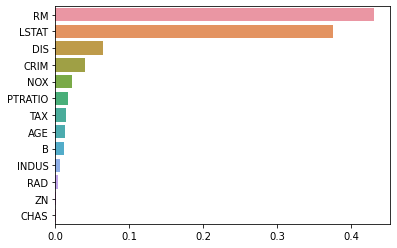

In [116]:
sns.barplot(x= feature_series, y = feature_series.index)

**보스톤의 불편한 진실 - LSTAT(하위 계층의 거주비율)이 보스톤 집값 예측에 영향이 크다는 것을 알수있다.**

**일부 특정 피처와 집값과의 분포_산점도**

In [132]:
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


(100, 3)


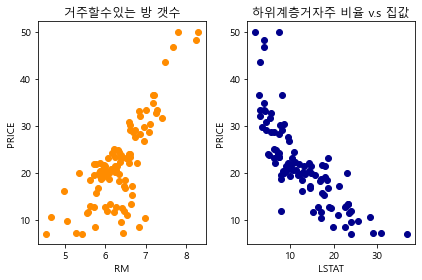

In [143]:
bostonDF_sample = bostonDF[['RM', 'PRICE', 'LSTAT']]
bostonDF_sample = bostonDF_sample.sample(n = 100, random_state = 156)
print(bostonDF_sample.shape)
plt.figure()

plt.subplot(121)  # 행은 1개 , 컬럼 2개, 1 - 첫번째 그래프 
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
plt.xlabel("RM")
plt.ylabel("PRICE")
plt.title("거주할수있는 방 갯수")

plt.subplot(122)  # 행은 1개 , 컬럼 2개, 2 - 첫번째 그래프 
plt.scatter(bostonDF_sample.LSTAT, bostonDF_sample.PRICE, c ="darkblue")
plt.xlabel("LSTAT")
plt.ylabel("PRICE")
plt.title("하위계층거자주 비율 v.s 집값")

plt.tight_layout()  # 이미지가 겹쳐보이래 처리 .

plt.show()

In [146]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 선형회귀와 결정 트리 기반의 Regressor생성, DecisionTreeRegressor의 max_depths는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

In [155]:
# 실제 예측을 적용할 테스트 데이터 세트를 4.5 ~ 8.5까지의 100개 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)
X_test.shape

(100, 1)

In [160]:
#보스톤 주택가격 데이터에서 시각화를 위해 피처는 RM만 , 그리고 결정인 PRICE추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target  = bostonDF_sample['PRICE'].values.reshape(-1, 1)


#학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_ref2 = rf_reg2.predict(X_test)
pred_ref7 = rf_reg7.predict(X_test)

#### LinearRegression과 DecisionTreeRegressor회귀선 보기 

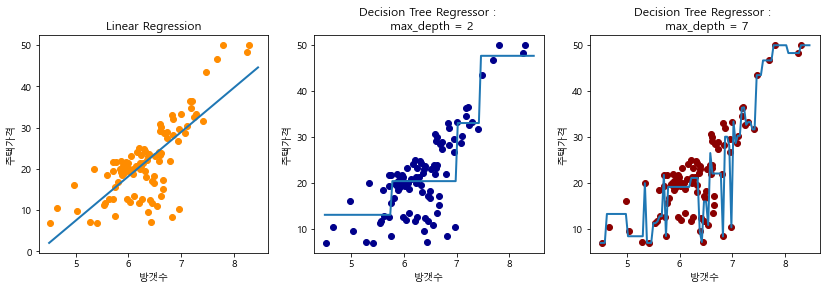

In [169]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14, 4), ncols = 3) 

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title("Linear Regression")
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax1.plot(X_test, pred_lr, label = 'Linear', linewidth = 2)
ax1.set_xlabel("방갯수")
ax1.set_ylabel("주택가격")
# DecisionTreeRegressor의 max_depth를 2로 했을때 회귀 예측선
ax2.set_title("Decision Tree Regressor : \n max_depth = 2")
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkblue')
ax2.plot(X_test, pred_ref2, label = 'DecisionTree Regressor 2', linewidth = 2)
ax2.set_xlabel("방갯수")
ax2.set_ylabel("주택가격")

# DecisionTreeRegressor의 max_depth를 2로 했을때 회귀 예측선
ax3.set_title("Decision Tree Regressor : \n max_depth = 7")
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkred')
ax3.plot(X_test, pred_ref7, label = 'DecisionTree Regressor 7', linewidth = 2)
ax3.set_xlabel("방갯수")
ax3.set_ylabel("주택가격")
plt.show()

**선형회귀는 직선으로 예측회귀선을 표현하는데 반해 , 회귀트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만든다. DecisionTreeRegressor의 max_depth인 경우에는 학습 데이터세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 됨.**